## Fitting a Bayesian model by sampling from a posterior distribution with a Markov chain Monte Carlo method

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data
df = pd.read_csv('https://github.com/ipython-books/'
    'cookbook-2nd-data/blob/master/'
    'Allstorms.ibtracs_wmo.v03r05.csv?'
    'raw=true',
    delim_whitespace=False)

Get the annual number of storms in the North Atlantic Ocean

In [3]:
cnt = df[df['Basin'] == ' NA'].groupby('Season')['Serial_Num'].nunique()
# The years from 1851 to 2012
years = cnt.index
y0, y1 = years[0], years[-1]
arr = cnt.values

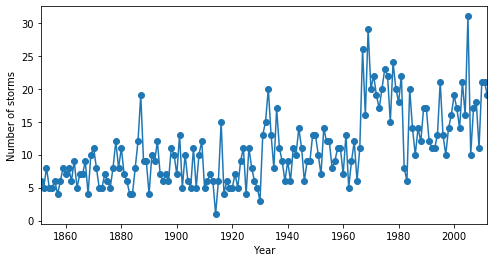

In [4]:
# plot the annual number of storms
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(years, arr, '-o')
ax.set_xlim(y0, y1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of storms');

We define our probabilistic model. We assume that the storms arise following a time-dependent **Poisson Process** with a deterministic rate. We assume that this rate is a piecewise constant function that takes a first value `early_mean` before a switch point `switch_point` and a second value `late_mean` after that point. These three unknown parameters are treated as random variables. In the model, the annual number of storms per year follows a Poisson distribution (a property of Poisson processes)

In [5]:
# We define our model
with pm.Model() as model:
    # We define our three variables.
    switchpoint = pm.DiscreteUniform(
    'switchpoint', lower=y0, upper=y1)
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    # The rate of the Poisson process is a piecewise
    # constant function.
    rate = pm.math.switch(switchpoint >= years,
    early_rate, late_rate)
    # The annual number of storms per year follows
    # a Poisson distribution.
    storms = pm.Poisson('storms', rate, observed=arr)

Now we sample from the posterior distribution given the observed data. The `sample(10000)` method launches the fitting iterative procedure with 10000 iterations, which may take a few seconds:

In [6]:
with model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:17<00:00, 2464.00draws/s]
The acceptance probability does not match the target. It is 0.8830182865953997, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789016914856713, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb4109eb8>,
      dtype=object)

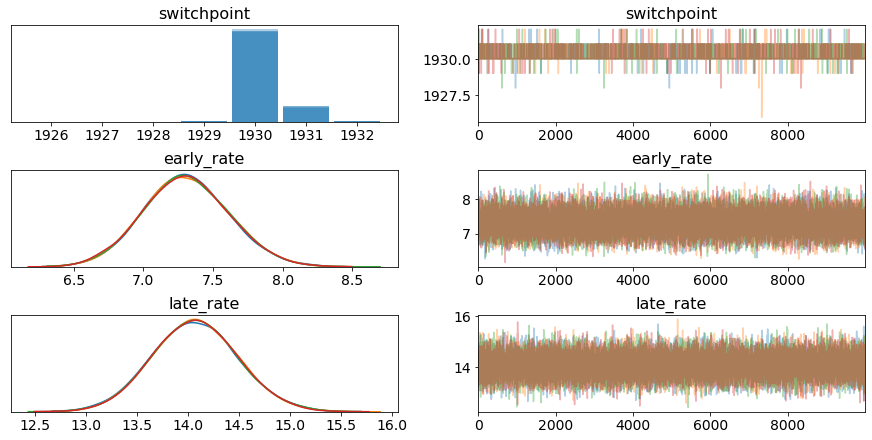

In [7]:
pm.traceplot(trace)

In [8]:
s = trace['switchpoint'].mean()
em = trace['early_rate'].mean()
lm = trace['late_rate'].mean()
s, em, lm

(1930.145725, 7.3098415809127415, 14.070450723264765)

Plot the estimated rate on top of the observations:

Text(0, 0.5, 'Number of storms')

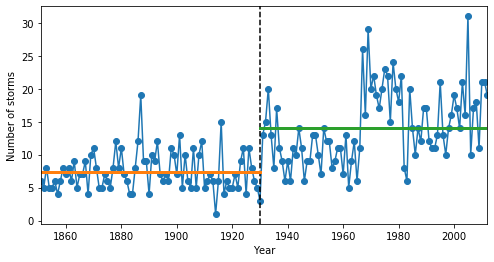

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(years, arr, '-o')
ax.axvline(s, color='k', ls='--')
ax.plot([y0, s], [em, em], '-', lw=3)
ax.plot([s, y1], [lm, lm], '-', lw=3)
ax.set_xlim(y0, y1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of storms')

### How it works
The general idea is to define a Bayesian probabilistic model and to fit it to the data. This model may be the starting point of an estimation or decision task. The model is essentially described by stochastic or deterministic variables linked together within a Directed Acyclic Graph (**DAG**). A is linked to B if B is entirely or partially determined by A. 

In [19]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(['late_mean', 'early_mean','switch_point','rate','storms'])
G.add_edges_from([('late_mean', 'rate'), ('early_mean', 'rate'), ('switch_point', 'rate'), ('rate', 'storms')])
G.graph['graph'] = {'rankdir': 'TB'}
G.graph['node'] = {'shape': 'circle'}
p = nx.drawing.nx_pydot.to_pydot(G)
p.write_png('rate.png')

<img src='./rate.png' width=300>